**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
November 13, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 2: “Sequence Models”**
**Due**: Monday, November 27, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: Part-of-Speech Tagging with a Bidirectional LSTM**  (2+4+5=11 points)

In this task we will be building a sequence tagger that produces an output for every element in an input sequence, using `PyTorch` and `TorchText`, where `TorchText` consists of data processing utilities and popular datasets for natural language.


*   **input:** a sequence of text
*   **output:** part-of-speech (POS) tag for each token in the input text

We tackle this task using a multi-layer bi-directional LSTM (BiLSTM) to predict POS tags using the [Universal Dependencies](https://universaldependencies.org/) English Web Treebank (UDPOS) dataset. This dataset is contained in the `TorchText` library and we do not require an external file for it. The dataset in  `TorchText`  has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We only focus on the UD tags for this assignment.

In [2]:
%pip install portalocker

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchdata

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import UDPOS

import numpy as np

import time
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for reproducibility
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.backends.cudnn.deterministic = True

/Users/sandrafriebolin/miniconda3/envs/nlp-transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Subtask 1: Data Analysis
The very basic components of the torchtext library include `vocab`, `word vectors`, and `tokenizer`. Those are the basic data processing building blocks for the raw text string.
In this case, we use the tokenizer and the vocabulary. Use the `build_vocab_from_iterator` to create the vocabulary for the text field and add the `<unk>` and `<pad>` tokens to it. Use a minimal frequency of `2`.
Also create a vocabulary for the labels (tag field). However, since the tags are predefined elements, you will not need an `<unk>` token.
 This dataset actually has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We train our model on the UD tags, which is the second element on the list of outputs (example below).


In [6]:
train_iter = iter(UDPOS(split="train"))
print(next(train_iter))

[['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']]


In [7]:
print(f"Number of training examples: {len(list(UDPOS(split='train')))}")
print(f"Number of validation examples: {len(list(UDPOS(split='valid')))}")
print(f"Number of testing examples: {len(list(UDPOS(split='test')))}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


Note that the data is already tokenized!

In [8]:
train_iter = UDPOS(split="train") # to get the training set

### your code (make sure pad has id of 0) ####
# Function to yield tokens from dataset
def yield_tokens(data_iter, index):
    for data in data_iter:
        yield data[index]

# Build vocabulary for text field
# Ensure <pad> is the first special token so it gets index 0
vocab = build_vocab_from_iterator(yield_tokens(train_iter, 0), min_freq=2, specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])

# Reset train_iter for UD tags
train_iter = UDPOS(split="train")

# Build vocabulary for UD tags
# No need to set <pad> index as it's the only special token and will automatically get index 0
ud_vocab = build_vocab_from_iterator(yield_tokens(train_iter, 1), specials=['<pad>'])
ud_vocab.set_default_index(ud_vocab['<pad>'])

#test
print(vocab(["<unk>", "<pad>", "news"]))
print(ud_vocab(["<pad>", "PUNCT", "ADJ"]))

[1, 0, 708]
[0, 2, 8]


Prepare a text processing pipeline that takes raw input and labels and converts them to ids.

In [9]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: ud_vocab(x)

In [10]:
print(text_pipeline(['the', 'preacher', 'at', 'mosque', "<pad>","pppp"])) #should output [3, 9271, 35, 9097, 0, 1]
print(label_pipeline(['DET', 'ADJ', 'NOUN', 'PUNCT'])) # should output [6, 8, 1, 2]

[3, 9271, 35, 9097, 0, 1]
[6, 8, 1, 2]


In [11]:
print(f"Unique tokens in input vocabulary: {len(vocab)}")
print(f"Unique tokens in UD vocabulary: {len(ud_vocab)}")

Unique tokens in input vocabulary: 9875
Unique tokens in UD vocabulary: 18


Write a custom function for the dataloader that applies the text and label pipeline and pads the sequences to have equal lengths.

In [12]:
from functools import partial
from torch import tensor

def collate_batch(batch, pad_token_ix, pad_token_ix_ud):
    text_list, label_list = [], []

    for (_text, _label, _) in batch:
        processed_text = text_pipeline(_text)
        processed_label = label_pipeline(_label)
        text_list.append(tensor(processed_text, dtype=torch.int64))
        label_list.append(tensor(processed_label, dtype=torch.int64))

    # Find the maximum length in the batch for both text and labels
    max_length_text = max([len(x) for x in text_list])
    max_length_label = max([len(y) for y in label_list])

    # Pad the sequences manually
    padded_text_list = [torch.cat([x, torch.full((max_length_text - len(x),), pad_token_ix, dtype=torch.int64)]) for x in text_list]
    padded_label_list = [torch.cat([y, torch.full((max_length_label - len(y),), pad_token_ix_ud, dtype=torch.int64)]) for y in label_list]

    # Stack padded sequences
    x_padded = torch.stack(padded_text_list)
    y_padded = torch.stack(padded_label_list)

    return x_padded.to(device), y_padded.to(device)

collate_fn = partial(collate_batch, pad_token_ix=vocab['<pad>'], pad_token_ix_ud=ud_vocab['<pad>'])

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    UDPOS(split="train"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    UDPOS(split="valid"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    UDPOS(split="test"), batch_size=128, shuffle=True, collate_fn=collate_fn
)

In [13]:
for idx, (label, text) in enumerate(train_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break

torch.Size([128, 57])
torch.Size([128, 57])
tensor([1832,   13,   17,  488, 2837,    3, 3074,    1, 5532,  512,   13,   23,
          56,  143,    5,  170,  154,  273,   39,  157,  971,   44, 2212,  648,
           2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([14,  4,  9, 12,  3,  6,  1,  1, 10, 17,  4,  3, 10, 13,  5, 13,  1, 10,
        14,  9,  3,  5,  7,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])


Let's take a closer look at the data and the distribution of tags.
Implement `tag_percentage`:

*   Use the `collection.counter` to count the unique instances of each tag.

*    Compute the percentage of each tag in the entire set, by using the counted frequencies.



In [14]:
from collections import Counter

def tag_percentage(training_iterator):
    counter = Counter()
    #### your code to count the number of tags
    for (_text, tags, _) in training_iterator:   
        counter.update(tags)    #update counter with batch's tags

    ### compute the tag percentages based on the counter object
    total_tags = sum(counter.values())
    tag_p = [(tag, count, (count/total_tags)) for tag, count in counter.items()]   #precentages

    return tag_p

In [15]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UDPOS(split='train')):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

PROPN		12946		 6.3%
PUNCT		23679		11.6%
ADJ		12477		 6.1%
NOUN		34781		17.0%
VERB		23081		11.3%
DET		16285		 8.0%
ADP		17638		 8.6%
AUX		12343		 6.0%
PRON		18577		 9.1%
PART		5567		 2.7%
SCONJ		3843		 1.9%
NUM		3999		 2.0%
ADV		10548		 5.2%
CCONJ		6707		 3.3%
X		847		 0.4%
INTJ		688		 0.3%
SYM		599		 0.3%


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: The Model

We start by creating a simple model and then make it more complex in later subtasks. The class `BiLSTMTagger` must subclass the `nn.Module` class of `PyTorch`. Fill the blank in the class by following the notes described below.
1.   The input is a sequence of tokens, $X = \{x_1, x_2,...,x_T\}$.
2.   Each token passes through  an embeddings layer, $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$. Use `nn.Embedding` for the embedding layer and make sure to pass in the index of the pad token.
3. Embedding is processed by forward and backward LSTMs from left to right and right to left.  The first input to the forward LSTM is $x_1$ and the first input to the backward LSTM is $x_T$. The hidden state of LSTMs is dependent on
the hidden, $h$, and cell, $c$, states from the previous time-steps:
$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
4. The hidden, $h$, and cell, $c$ of each layer is passed to the next layer, where the $h_0$ and $c_0$, for each direction and layer, are initialized to a tensor full of zeros. Use `nn.LSTM` for LSTM cells. How can you make it bidirectional?
5. Final hidden state is the concatenation of forward and backward hidden states from the final layer of the LSTM, $H = \{h_1, h_2, ... h_T\}$, where $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$. Use `nn.Linear` here.
6. The last layer is linear layer $f$, which is used to make the prediction of which tag applies to this token, $\hat{y}_t = f(h_t)$.
7. Define a `nn.Dropout` layer to apply to the embeddings and the outputs of the final layer of the LSTM.

In [16]:
class BiLSTMTagger(nn.Module):
    def __init__(self, hyperparameters):
      '''
      hyperparameters: is a dictionary containing:
                 input_dim: dimension of the input
                 embedding_dim: dimension of the embedding layer
                 lstm_hidden_dim: dimension of the hidden state of lstms
                 output_dim: dimension of the output hidden layer
                 n_layers: number of layers to stack
                 bidirectional: is the lstm bi-directional
                 dropout: probability for the drop out layer
                 pad_idx: id of the pad token
      '''
      super().__init__()
      #### your code ####
      # Unpacking hyperparameters
      input_dim = hyperparameters['input_dim']
      embedding_dim = hyperparameters['embedding_dim']
      lstm_hidden_dim = hyperparameters['lstm_hidden_dim']
      output_dim = hyperparameters['output_dim']
      n_layers = hyperparameters['n_layers']
      bidirectional = hyperparameters['bidirectional']
      dropout = hyperparameters['dropout']
      pad_idx = hyperparameters['pad_idx']

      # Embedding layer
      self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

      # Bi-LSTM layer
      #apply dropout if the number of layers is more than 1
      self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=(dropout if n_layers > 1 else 0))

      # Fully connected layer
      self.fc = nn.Linear(lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim, output_dim)

      # Dropout layer
      self.dropout = nn.Dropout(dropout)


    def forward(self, text, debug=False): #(B,S)
      '''
      S: sentence len
      B: batch size
      E: embedding size
      H: hidden size
      O: output size
      L: number of layers
      '''
      #### your code ####
      # Embedding layer
      embd = self.dropout(self.embedding(text))  # (S, B, E)

      # LSTM layer
      outputs, (hidden, cell) = self.lstm(embd)

      # Apply dropout to the output of LSTM layer
      outputs = self.dropout(outputs)

      # Linear layer
      predictions = self.fc(outputs)

      if debug==True:
        print("Input shape:",text.shape)
        print("Embedding shape:",embd.shape)
        print("LSTM output shape:",outputs.shape)
        print("LSTM hidden shape:",hidden.shape)
        print("LSTM cell shape:",cell.shape)
        print("Output shape:",predictions.shape)

      return predictions

Response in plain text:
1. Based on the notation defined in the forward function. What is the dimension of `outputs`, `hidden`, and `cell`?

`outputs`: (sentence len, batch size, hidden size * 2)

`hidden`: (num of layers * 2, batch size, hidden size)

`cell`: (num of layers * 2, batch size, hidden size)

(because the LSTM is bidirectional: 2 = num directions)


In [17]:
hyper_parameters={
  'input_dim':  len(vocab),
  'embedding_dim': 100,
  'lstm_hidden_dim': 128,
  'output_dim':len(ud_vocab),
  'n_layers': 2 ,
  'bidirectional':True,
  'dropout': 0.25,
  'pad_idx': vocab['<pad>']
}
model = BiLSTMTagger(hyper_parameters)

In [18]:
input=torch.tensor([[3, 9271, 35, 9097, 0, 1],
                    [3, 9271, 35, 9097, 0, 1]])
model(input,debug=True).shape

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([4, 6, 128])
LSTM cell shape: torch.Size([4, 6, 128])
Output shape: torch.Size([2, 6, 18])


torch.Size([2, 6, 18])

Weights of the network are initialized randomly, so let's make a more systematic initialization to help us with the optimization. For example,  Xavier Initialization creates weights such that the variance of the activations is the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. However, it does not apply to bias terms.

Create a function that uses Xavier Initialization to initialize the weights of the network, for biases use a normal distribution with a mean of 0 and a standard deviation of 0.1.

In [19]:
def init_weights(m):
  ### you code ###
  if isinstance(m, nn.LSTM):
      for name, param in m.named_parameters():
          if 'weight_ih' in name:
              nn.init.xavier_uniform_(param.data)
          elif 'weight_hh' in name:
              nn.init.orthogonal_(param.data)
          elif 'bias' in name:
              nn.init.constant_(param.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight.data)
      nn.init.normal_(m.bias.data, mean=0, std=0.1)
  elif isinstance(m, nn.Embedding):
      nn.init.uniform_(m.weight.data, -0.1, 0.1)
  ### your code ###
model.apply(init_weights)
model.to(device)

BiLSTMTagger(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Let's count the number of trainable parameters in our model.

In [20]:
def count_parameters(model):
  ### your code ###
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  ### your code ###

print("number of trainable parameters:", count_parameters(model))

number of trainable parameters: 1622910


####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Training

We start by defining a loss function and an optimizer.


*   **optimizer:** We use Adam with the learning rate=0.0001.
*   **loss:** We use cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens to create batches of the same size. However, we do not want to calculate loss on those tokens, so make sure you define your loss function in such a way that ignores the `<pad>` tokens.




In [21]:
### your code ###
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# The CrossEntropyLoss will ignore the <pad> tokens in the loss calculation
pad_idx = hyper_parameters['pad_idx']
loss_function = nn.CrossEntropyLoss(ignore_index=pad_idx)

### your code ###

Watching the loss go down as you train a model is a good indication of the correct training procedure, but does not tell us how well we are doing on a given task.
To this end, we also implement a categorical accuracy measure to keep track of how well our model is doing on a given task.
Same as before: we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.
Implement the function `categorical_acc` to compare the prediction of non-pad tokens with labels count the correct ones and calculate the accuracy over a single batch.

In [22]:
def categorical_acc(preds, gt, pad_idx):
    """
    Returns categorical accuracy per batch
    preds: predictions from the model [batch size, sentence length, output dim] or [sentence length, output dim]
    gt: ground truth labels [batch size, sentence length] or [sentence length]
    pad_idx: index of the pad token
    """
    ### your code ####
    # Add a batch dimension if it's not present
    if preds.dim() == 2:
        preds = preds.unsqueeze(0)
    if gt.dim() == 1:
        gt = gt.unsqueeze(0)

    # Get the index of the max probability
    max_preds = preds.argmax(dim=2, keepdim=True)  # [batch size, sentence length, 1]
    
    # Flatten both max_preds and gt to compare element-wise; ignore <pad> tokens
    non_pad_elements = (gt != pad_idx).nonzero(as_tuple=True)
    correct = max_preds[non_pad_elements].squeeze(1).eq(gt[non_pad_elements])

    # Calculate accuracy
    return correct.sum() / torch.FloatTensor([gt[non_pad_elements].shape[0]])

In [23]:
dummpy_input=torch.tensor([
    [0.9,0,0,0],
    [0.1,0.9,0,0],
    [0.1,0,0,0.9],
    [0.9,0.1,0,0],
    [0.1,0.8,0,0]

])
categorical_acc(dummpy_input, torch.tensor([0,2,3,0,1]), 0)

tensor([0.6667])

Define the `train` model that performs one epoch of training. You can refer to the Tutorial 2 of the course to get a sample workflow. The only difference to the tutorial is that we keep track of the batch-wise accuracy as well as the loss.

In [24]:
def train(model, dataloader, optimizer, loss_function, pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    epoch_start_time = time.time()

    for length_dataloader, (text, tags) in enumerate(dataloader):
        #### your code ####
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(text)

        # Reshape predictions and tags for calculating loss and accuracy
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        # Compute the loss and accuracy, ignoring pad tokens
        loss = loss_function(predictions, tags)
        acc = categorical_acc(predictions, tags, pad_idx)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #### your code ####

    end_time= time.time() - epoch_start_time

    return epoch_loss / length_dataloader, epoch_acc / length_dataloader, end_time

It is not enough to only look at the training loss and accuracy, since with more training, we can always do better on the training set, but lose the generalizability to unseen data, a phenomenon known as **overfitting**. Therefore, it is important to check the loss and accuracy on the validation set after each epoch and stop before  overfitting occurs. Moreover, we can use the validation metric as an indication of which checkpoint of our model is the best.

Define an `evaluate` function that runs once through the validation set and computes loss and accuracy. **Note:** You should not be updating gradients here and your model should be in evaluation mode.

In [25]:
def evaluate(model, dataloader, loss_function, pad_idx):

    val_loss = 0
    val_acc = 0

    ### your code ###
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient computation
        for length_dataloader, (text, tags) in enumerate(dataloader):
            # Forward pass
            predictions = model(text)

            # Reshape predictions and tags for calculating loss and accuracy
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            # Compute the loss and accuracy, ignoring pad tokens
            loss = loss_function(predictions, tags)
            acc = categorical_acc(predictions, tags, pad_idx)

            # Accumulate loss and accuracy
            val_loss += loss.item()
            val_acc += acc.item()
    ### your code ###

    return val_loss / length_dataloader, val_acc / length_dataloader

Let's use the functions defined so far and train our model for `30` epochs. We suggest using GPU for this task, as it is quite slow on the CPU. Run the training loop for the given number of epochs and calculate the validation metric at the end of each epoch. Based on the validation loss, save the best checkpoint of the model.

In [26]:
from tqdm import tnrange

epochs = 30

best_valid_loss = float('inf')

for epoch in range(epochs):
    ### your code ###
    train_loss, train_acc, epoch_time = train(model, train_dataloader, optimizer, loss_function, pad_idx)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_function, pad_idx)

    # Save the model if the validation loss is the best we've seen so far.
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    ### your code ###
    
    elapsed_mins = int(epoch_time / 60)
    elapsed_secs = int(epoch_time - (elapsed_mins * 60))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')

/Users/sandrafriebolin/miniconda3/envs/nlp-transformers/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 2.743 | Train Acc: 14.97%
	 Validation Loss: 2.694 |  Validation Acc: 17.83%
Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 2.537 | Train Acc: 17.64%
	 Validation Loss: 2.630 |  Validation Acc: 22.47%
Epoch: 03 | Epoch Time: 0m 37s
	Train Loss: 2.418 | Train Acc: 23.81%
	 Validation Loss: 2.374 |  Validation Acc: 31.40%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 2.100 | Train Acc: 35.18%
	 Validation Loss: 1.936 |  Validation Acc: 46.17%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 1.702 | Train Acc: 48.42%
	 Validation Loss: 1.519 |  Validation Acc: 60.43%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 1.360 | Train Acc: 59.11%
	 Validation Loss: 1.232 |  Validation Acc: 66.04%
Epoch: 07 | Epoch Time: 0m 33s
	Train Loss: 1.119 | Train Acc: 66.48%
	 Validation Loss: 1.017 |  Validation Acc: 75.55%
Epoch: 08 | Epoch Time: 0m 41s
	Train Loss: 0.926 | Train Acc: 73.33%
	 Validation Loss: 0.839 |  Validation Acc: 81.87%
Epoch: 09 | Epoch Time: 0m 38s
	

Question:

1. Does overfitting occur? If so, after which epochs?

2. How do you detect overfitting?


**Answer:**
```
1. Does overfitting occur? If so, after which epochs?

    - No (due to the reasons/observations explained below).

2. How do you detect overfitting?

    - Check if the training loss decreases but the validation loss increases (which is not the case here)
    - Check if high training accuracy but low validation accuracy (also not the case: val acc is even a little higher in most cases)

    -> Both training and validation loss decrease and accuracies increase over epochs, which is a good sign that no overfitting occurs and the model learns effectively. Also, training and validation accuracy are quite close to each other, and their loss values are converging, which further suggests that the model is not overfitting significantly.
```

Let's see how well our model is doing on the test set. Load the best checkpoint and calculate the accuracy.

In [27]:
#### you code ####
# Load best saved model checkpoint
model.load_state_dict(torch.load('best-model.pt'))
#### you code ####

# Evaluate the model on the test set
test_loss, test_acc = evaluate(model, test_dataloader, loss_function, pad_idx)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.466 | Test Acc: 89.93%


####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Inference

Let's use the model we trained to tag some actual sentences. We have the preprocessing pipeline ready from Subtask 1, now we need to map the predictions back to label texts for each token.

Implement the `tag_sequence` function that takes a model and a sentence as input and generates POS tags. Keep in mind that you need to divide the sentence into tokens first. For this purpose, we just split each sentence on whitespaces.

In [28]:
def tag_sentence(model, sentence):
    ### your code ###
    # Tokenize
    tokens = sentence.split()

    # Convert tokens to ids
    token_idx = [vocab[token] if token in vocab else vocab["<unk>"] for token in tokens]

    # Convert to a tensor and add an extra dimension for batch
    token_tensor = torch.LongTensor(token_idx).unsqueeze(-1).to(device) #add extra dimension to match expected input dimensions

    # Predict with the model
    model.eval()
    with torch.no_grad():
        predictions = model(token_tensor) # make predictions on the sentence

    # Convert predictions to tag indices
    #find index of max value, then remove unnecessary extra dimension, then move tensor to CPU to convert it to numpy array
    predicted_idx = predictions.argmax(-1).squeeze(-1).cpu().numpy()   

    # Get the mapping from indices to tags
    idx_to_tags = ud_vocab.get_itos() 

    # Convert indices to tags
    predicted_tags = [idx_to_tags[idx] for idx in predicted_idx] # get the tags

    return predicted_tags

In [29]:
text=" ".join(list(UDPOS(split='test'))[0][0])
label= list(UDPOS(split='test'))[0][1]
predicted_tag=tag_sentence(model, text)
print("Text: ", text)
print("Predicted Tags: ", predicted_tag)
print("True Tags: ", label)

Text:  What if Google Morphed Into GoogleOS ?
Predicted Tags:  ['PRON', 'SCONJ', 'PROPN', 'PROPN', 'PROPN', 'NUM', 'PUNCT']
True Tags:  ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


####${\color{red}{Comments\ 1.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Theoretical Questions** (0.5+1.5+1+3=6 points)

### Subtask 1:
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

**Answer:**


```
a) Runtime and Memory: Increasing beam width leads to longer runtime and higher memory usage, as the algorithm evaluates and stores more candidate sequences: the number of paths considered at each step of the search increases and the algorithm needs to store a larger number of partial sequences.

b) Quality of Results: A larger beam width generally improves result quality by exploring more sequences and making it less likely to miss the optimal or a high-quality sequence. But there's a diminishing return on quality improvement beyond a certain width as the increase in quality becomes marginal compared to the additional computational cost, and it could introduce noise.

```

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2:
Except for beam search, there are other ways to create a more coherent output for generation tasks, one of which is adding a temperature to the softmax over the vocabulary. Temperature is a hyperparameter that is applied to the input of a softmax to affect the final probabilities. All values in the input are divided by the temperature before going through the softmax. What do you think will happen in these cases:

1. A low temperature - below 1
2. A high temperature - above 1
3. Really small temperature - temperature $→$ 0

**Answer:**
```
Low Temperature (below 1): Concentrates probability on the highest-scoring words, leading to more confident and less diverse choices, as it reduces the chances for less likely words.

High Temperature (above 1): Results in a flatter output distribution by smoothing the probability, increasing diversity and randomness as it gives lower-scoring words a higher chance of being chosen.

Really Small Temperature (approaching 0): Maximizes the probability of the top word, causing the model to almost always pick the most probable word and reducing randomness to nearly zero.

```

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3:
Explain what the “bottleneck” of an encoder-decoder RNN is and how attention provides a way to get around this bottleneck.

**Answer:**
```
The "bottleneck" happens because the entire input sequence is compressed into a fixed-length context vector in an RNN, which makes it difficult to keep all relevant information for long sequences. Attention overcomes this by as it lets the decoder selectively focus on various parts of the input sequence at each step of the output generation. It thus creates a dynamic, context-specific representation and avoids the limitations of single, fixed-length vectors.
```

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4:
As mentioned, there are various way to remedy the repetitiveness and incoherence of generation outputs. One of the widely used methods is Nucleus sampling described the paper "[The Curious Case of Neural Text DeGeneration](https://arxiv.org/pdf/1904.09751.pdf)". Read the model section and introduction of the paper and use it as reference to answer the following questions:

1. Describe top-k sampling in your own words, no need for mathematical notation.
2. Describe Nucleus sampling in your own words, there is not need for mathematical notation.
3. Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?


**Answer:**
```
1. Top-k sampling is a method in text generation where you pick from the top k most likely words at each step. The challenge is to to generate diverse but coherent text. The top k words can change based on the shape of the probability distribution at each time step. It usually gives better results than other methods like beam search. The tricky part is picking the right k - small k may lead to bland or generic text, while a large k may include inappropriate candidates, affecting the quality of the generated text

2. Nucleus sampling is another way to generate text. It picks from a changing set of words, depending on how likely they are to come next, up to a certain probability (the p value). This method aims to address the limitations of top-k sampling by dynamically adjusting the size of the sampling set based on the shape of the probability distribution at each time step. This way, it can avoid some common issues like repeating stuff or using too many plain words, making the text sound more natural and interesting

3. Using likelihood as the main goal for training language models can be smart, but when it comes to actually creating text, like with beam search, you can end up with stuff that doesn't sound quite right or repeats a lot.  This is counterintuitive, as one would expect good models to assign higher probability to more human-like, grammatical text. However, the text generated by beam search tends to be generic and less interesting, as it assigns high probability to generic and repetitive text. That's why methods like top-k or nucleus sampling are handy as they keep adjusting what words they choose from as they write, helping the text stay interesting and varied.
```

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Scaled Dot-Product Attention** (4+1=5 points)
In class, you learned about attention and Transformers as described in the 2017 paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762).
The base of the attention module is a scaled dot product with Queries, Keys, and Values.
In this task, you will implement a simplified version of scaled dot-product attention and inspired by the translation task, aim to replicate word alignment between English and French.
You will not be training the embedding from scratch, we provide you with pre-trained embedding for both languages.
However, you need to know the details of scaled dot product attention, which mainly consists of two matrix multiplications and a softmax scaling.
Refer to Figure 2 of the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

The inputs of the attention module are Queries, Keys, and Values. Mathematically, attention is defined as follows:

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$


*   $Q$, $K$, and $V$ are the Queries, Keys, and Values matrices.
* $d_k$ is the dimension of the Keys (in practice dimensions of all matrices are the same).
*   $QK^{\top}$ is a measure of the similarity between the Queries and the Keys
* softmax transforms the similarity into weights.
* Weights multiplied by the Values are the output of the attention, defining how much importance should be given to each token of the input.

In the case of self-attention, both Queries and Keys come from the encoder, however, for cross attention between encoder and decoder, decoder states are used as the queries while encoder states are the Keys and Values.
In our case, we need the cross attention between one language to another to find the correct alignment.


In [30]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#load the dictionaries (dictionary of words to ids)
with open("./word2int_en.pkl", "rb") as f:
    en_dict = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
    fr_dict = pickle.load(f)

# load word embeddings (dictionary of token ids to embeddings)
en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]


### Subtask 1: Attention Weights
Fill the blanks in `tokenize` to tokenize a sentence and convert it to ids and `embed` function to create an embedding of a sentence.

In [2]:
def tokenize(sentence, token_mapping):
   # we stick to simple blank space tokenization
   tokenized = []
   for word in sentence.lower().split(" "):
       
       if word in token_mapping:
           token = token_mapping[word]
       else:
           token = -1
       tokenized.append(token)

   return tokenized

def embed(tokens, embeddings):
    """ get the embedding for the tokens in a sentence stacked in a simple matrix (sequence length, embedding size)
        tokens: tokenized sentence
        embeddings: dictionary of token to embeddings.
    """
    embed_size = embeddings.shape[1]
    embed_list = []
    for token in tokens:
        if token == -1:
            embed_list.append(np.zeros(embed_size))
        else:
            embed_list.append(embeddings[token])
        output = np.stack(embed_list)
        
    return output

In [3]:
sentence_en = "there were clouds in my coffeeeeee."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)
print("Tokenized english:",tokenized_en)
print("embedding english:",embedded_en.shape)

sentence_fr = "il y avait des nuages ​​dans mon ccafé."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
print("Tokenized french:",tokenized_fr)
print("embedding french:",embedded_fr.shape)

Tokenized english: [59, 40, 9355, 6, 158, -1]
embedding english: (6, 300)
Tokenized french: [21, 73, 192, 16, 8652, -1, 558, -1]
embedding french: (8, 300)



Implement the `softmax` function with `Numpy`.


In [4]:
def softmax(x, axis=0):
    """
    x: input matrix
    axis: defines which axis to compute the softmax over 0 for rows and 1 for columns
        axis=0 calculates softmax across rows which means each column sums to 1
        axis=1 calculates softmax across columns which means each row sums to 1
    """

    # softmax(x_i) = e^{x_i} / \sum{j=1}^{K}e^{x_j}
    dividend = np.exp(x)
    divisor = np.sum(np.exp(x), axis=axis, keepdims=True)

    softmax_x = dividend / divisor

    return softmax_x

In [5]:
w=softmax(np.array([[1,3,4,1], [24,3,2,3]]),axis=0)
w.sum(axis=0)[0]

1.0

Use the `softmax` function to calculate the weights.
$$ \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
Assume the queries and keys are 2D matrices.

In [6]:
def calc_weights(queries, keys):
    """
    queries: queries matrix
    keys: keys matrix
    """
    d_k = keys.shape[1]
    dot_product = np.dot(queries, keys.T)
    weights = softmax(dot_product / np.sqrt(d_k), axis=1)

    return weights

In [7]:
weights=calc_weights(np.array([[1,3],[1,3]]),np.array([[0,3],[2,3]]))
print(weights)
weights.sum(axis=1)[0]

[[0.19557032 0.80442968]
 [0.19557032 0.80442968]]


1.0

Use the `calcu_weights` to compute the attention matrix between two sentences from English and French and visualize the weights to check for alignments.

(4, 2) -> nuages, clouds, prob: 0.0937
(7, 5) -> café, coffee, prob: 0.0932


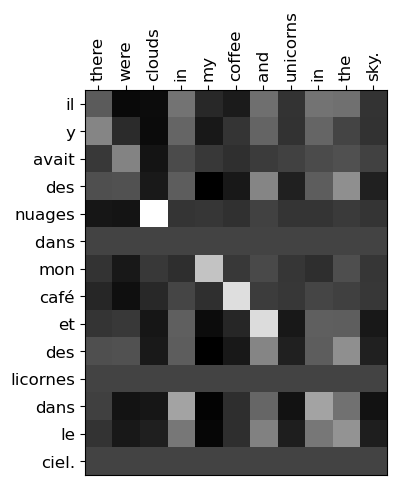

In [8]:
sentence_en = "there were clouds in my coffee and unicorns in the sky."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "il y avait des nuages ​​dans mon café et des licornes dans le ciel."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)

alignment = calc_weights(embedded_fr, embedded_en)
# visualize weights
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(alignment,cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=12);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=12);


### your code to compute the top-2 ###
top_n_words = 2

# Flatten the alignment array and get the indices of the top-n words
flat_alignment = alignment.flatten()
top_indices = np.argsort(flat_alignment)[-top_n_words:][::-1]

# Splitting sentences into words
english_words = sentence_en.split()
french_words = sentence_fr.split()

# Iterate through the top indices to find the corresponding words and their probabilities
for idx in top_indices:
    row = idx // alignment.shape[1]
    col = idx % alignment.shape[1]
    prob = flat_alignment[idx]
    print(f"({row}, {col}) -> {french_words[row]}, {english_words[col]}, prob: {prob:.4f}")


1. What are the top 2 alignments shown in the figure?
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?

**Answer:**

```
1. Top 2 Alignments:
    1. nuages - clouds
    2. café, coffee

2. The flat lines for ciel, dans, and licornes in the rows of the visualization occur because these words are not recognized by our tokenizer. 
Specifically, the punctuated forms "ciel." and "\u200b\u200bdans", along with "licornes", are absent from our French dictionary (fr_dict). 
As a result, these words are assigned zero embeddings.

When calculating the alignment between the French and English sentences, the corresponding rows for these unrecognized words contain only zeros. 
After applying the softmax function, which normalizes values across columns (because it was called with the axis 1), each cell in these rows gets an equal, small value (0.09090909090909091). 
This uniformity across the row creates the appearance of flat lines in the visualization.
```

####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Scaled Dot-product
Implement the scaled dot-product attention using the functions from above.



In [10]:
def attention(queries, keys, values):
    """  scaled dot-product attention
    queries: query matrix
    keys: key matrix
    value: value matrix
    """

    weights = calc_weights(queries, keys)
    attention = np.matmul(weights, values)
    
    return attention


attention_result = attention(embedded_fr, embedded_en, embedded_en)
print(attention_result.shape)
print(attention_result[0:2,:10])

(14, 300)
[[-0.0077802  -0.00345834 -0.01493142  0.05936939 -0.02286767 -0.00835552
   0.00079745 -0.03737862  0.0270674   0.05374082]
 [-0.00777829 -0.00336843 -0.01498988  0.05937157 -0.02285948 -0.00835695
   0.00085725 -0.03740797  0.02706951  0.05377672]]


####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$